# What is the One Piece

This is the first question one may ask beggining the series. After more than 25 years, the answer to that question remains unanswered, and even more mystery surrounds the topic.

The objective of this notebook is to "grasp" at a understandable level what the One Piece manga covers in it's text content (who knows, we may even find One Piece!). 

*Disclaimer: as there is currently no simple way of giving panel descriptions from the panels of the manga, this analysis will depend mostly from the transcriptions from the magi transformer.*

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud



# !python -m spacy download en_core_web_trf
import spacy
nlp = spacy.load("en_core_web_trf")

from top2vec import Top2Vec
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


def top_n_idx_sparse(matrix, n):
    """Return index of top n values in each row of a sparse matrix."""
    top_n_idx = []
    for le, ri in zip(matrix.indptr[:-1], matrix.indptr[1:]):
        n_row_pick = min(n, ri - le)
        top_n_idx.append(
            matrix.indices[
                le + np.argpartition(matrix.data[le:ri], -n_row_pick)[-n_row_pick:]
            ]
        )
    return top_n_idx


def preprocess_tokens(string: str) -> str:
    """Get a crude unprocessed string and return a filtered and standardized version of the input"""
    doc = nlp(string)
    out = [
        token.lemma_ for token in doc
        if token.pos_ in ("NOUN", "VERB")
    ]
    return " ".join(out)


def get_word_freq_by_group(string: str) -> str:
    pass

onepiecedata = pd.read_parquet("../outputs/volume.parquet")
onepiecedata.head(10)

,volume,text,saga,saga_expanded
0,1,why dont you do it youra self. you dont have t...,East Blue,Romance Dawn
1,2,buggys cannons blew the village to smtherens. ...,East Blue,Orange Town
2,3,could they have finished with him already. he ...,East Blue,Orange Town
3,4,your swords. before we fight id better. they c...,East Blue,Syrup Village
4,5,hes the cannon man. brother they say. captured...,East Blue,Baratie
5,6,better take it easy. whos krieg. then fight me...,East Blue,Baratie
6,7,ha you can tell youre a green horn. b bones. p...,East Blue,Baratie
7,8,hatchan hachi arlongs first mate. if some thin...,East Blue,Arlong Park
8,9,having seen the strong hold of this pirate. go...,East Blue,Arlong Park
9,10,is the maximum you can hold you have no chance...,East Blue,Arlong Park


# Analysing "Crude" Text

Let's take a look at the word count of every volume-saga so we can have an idea where most texts are located.

One major find I get while working on this is that the iconic laughs of One Piece are still present on this "polished" version of the dataset.

In [7]:
# First, take every row, split text by spaces and count length of resulting list.
onepiecedata["word_count"] = onepiecedata["text"].apply(lambda x: len(x.split()))
onepiecedata.head(2)

,volume,text,saga,saga_expanded,word_count
0,1,why dont you do it youra self. you dont have t...,East Blue,Romance Dawn,9898
1,2,buggys cannons blew the village to smtherens. ...,East Blue,Orange Town,6630


In [8]:
fig = px.bar(onepiecedata, x='volume', y='word_count', template='simple_white', title='Number of Words Per Volume')
fig.update_xaxes(categoryorder='total descending', title='Volume').update_yaxes(title='Number of words')
fig.show()

It may be more interesting to look at sagas, but as some sagas vary in size, I'll use median as aggregating function and plot median number of words per saga!

In [9]:
oneonepiecedata_by_saga = onepiecedata.groupby("saga")["word_count"].median().reset_index()
fig = px.bar(oneonepiecedata_by_saga, x='saga', y='word_count', template='simple_white', title='Median Number of Words Per Saga')
fig.update_xaxes(categoryorder='total descending', title='Saga').update_yaxes(title='Number of words')
fig.show()

Right away, I'm amazed to see that sagas with more **action** are definitely getting on the end of the list! This is already a amazing find, as we can expect to see more context on the story in sagas that are more "grounded" in a sense there is less going on! 

It's worth mentioning that there are some really short sagas there on the mix, meaning they are more prone to have more text just because, and it may be purely due to chance. (The reason this analysis won't make sense on sagas expanded!)

## Topn token analysis

Now that we have an idea on how words are being distributed along the dataset, let's look for common words being used along each volume!

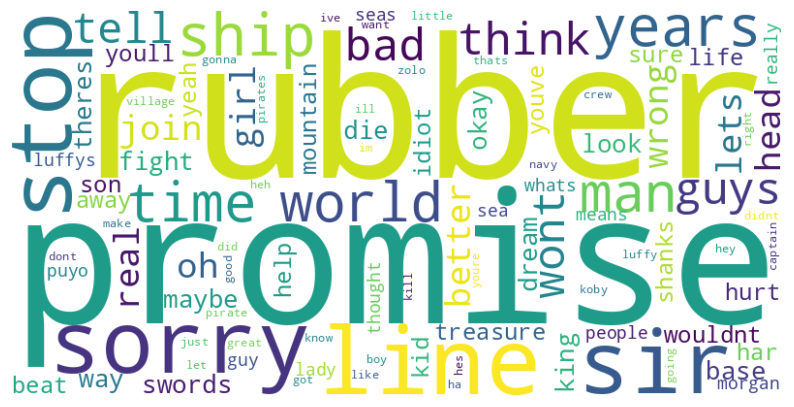

In [10]:
vectorizer = CountVectorizer(stop_words="english")
X = vectorizer.fit_transform(onepiecedata["text"])
words = vectorizer.get_feature_names_out()[top_n_idx_sparse(X, 100)][0]
sizes = X[0,top_n_idx_sparse(X, 100)[0]].toarray().ravel()
frequencies = {word:size for word in words for size in sizes}

wordcloud = WordCloud(
    width=400,
    height=200,
    scale=2,
    max_font_size=100, 
    background_color="white"
).generate_from_frequencies(frequencies=frequencies)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**If you are not familiar with NLP techniques, notice a important topic here!**

By simply looking at the output of the function above, I can see that there are some recurring words that hold no value whatsoever!

This happens because I counted all values locally considering the scope of a single volume, but when looking at the rest of the document, those words never appear again! Let's make a quick change here and use TFIDF as a way of removing those "bad" words from the mix.

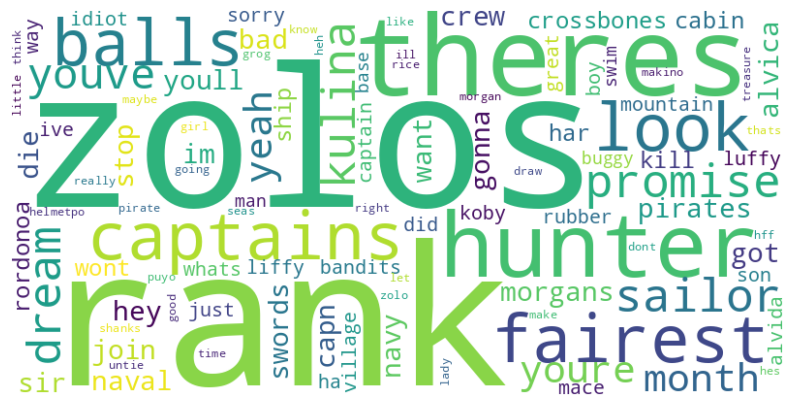

In [11]:
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(onepiecedata["text"])
words = vectorizer.get_feature_names_out()[top_n_idx_sparse(X, 100)][0]
sizes = X[0,top_n_idx_sparse(X, 100)[0]].toarray().ravel()
frequencies = {word:size for word in words for size in sizes}

wordcloud = WordCloud(
    width=400,
    height=200,
    scale=2,
    max_font_size=100, 
    background_color="white"
).generate_from_frequencies(frequencies=frequencies)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

It already looks better! But we can do even better... but how? Let's take a look on the semantics of a given volume topn words.

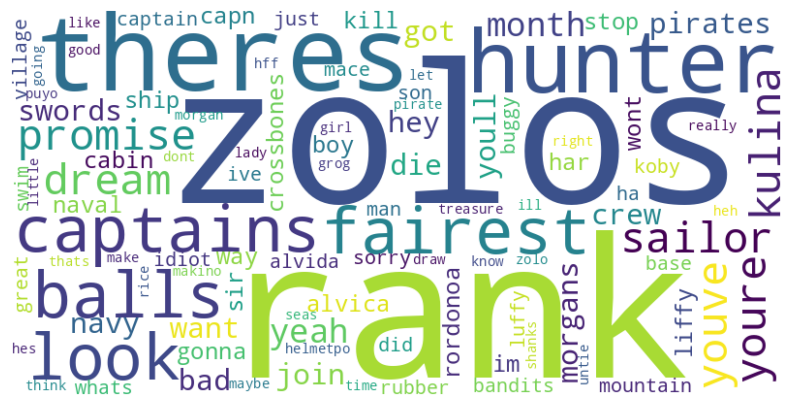

In [12]:
words = vectorizer.get_feature_names_out()[top_n_idx_sparse(X, 100)][0]
sizes = X[0,top_n_idx_sparse(X, 100)[0]].toarray().ravel()
frequencies = {word:size for word in words for size in sizes}

wordcloud = WordCloud(
    width=400,
    height=200,
    scale=2,
    max_font_size=100, 
    background_color="white"
).generate_from_frequencies(frequencies=frequencies)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

There is a lot of "noisy" words! Those can be personal names, typos, pronouns... the list is extensive. 

This is the big challenge of dealing with text data: scraping what is necessary. But... how to define that a specific word is necessary?

For this, I'll use [spacy](https://spacy.io/). My focus right now is to get english common words (verbs and nouns) to get a sense most used nonpersonal words by volume.

I'm interested in first standardize formats with a technique called lemmatization. After that, I'll be filtering tokens by taking the **Part of Speech(POS)** tags, which will return a more "robust" curation of tokens.

I've defined a custom function in the beggining of this document. Fell free to take a look!

In [13]:
# This entire process took 12 min to run. I'll cache results to keep my analysis
cache_path = "../outputs/processed_onepiecedata.parquet"
if os.path.isfile(cache_path):
    onepiecedata = pd.read_parquet("../outputs/processed_onepiecedata.parquet")
else:
    onepiecedata["processed_text"] = onepiecedata["text"].apply(lambda x:preprocess_tokens(x))
    onepiecedata.to_parquet("../outputs/processed_onepiecedata.parquet")

onepiecedata.head(2)

,volume,text,saga,saga_expanded,word_count,processed_text
0,1,why dont you do it youra self. you dont have t...,East Blue,Romance Dawn,9898,do self have untie s prison s guy think s idea...
1,2,buggys cannons blew the village to smtherens. ...,East Blue,Orange Town,6630,cannon blow village thank guard store shut s c...


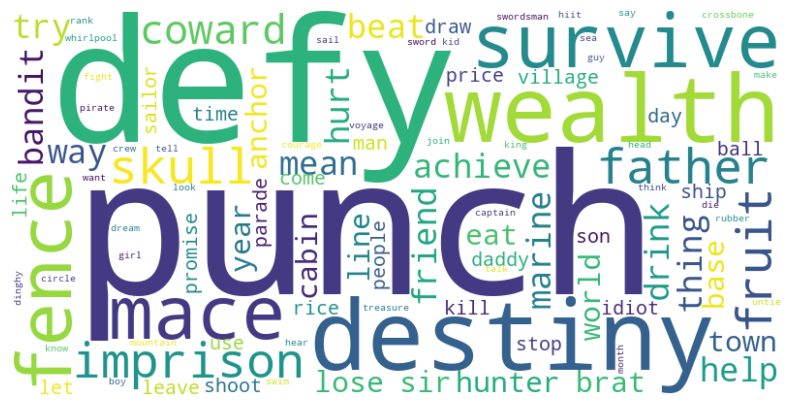

In [14]:
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(onepiecedata["processed_text"])

words = vectorizer.get_feature_names_out()[top_n_idx_sparse(X, 100)][0]
sizes = X[0,top_n_idx_sparse(X, 100)[0]].toarray().ravel()
frequencies = {word:size for word in words for size in sizes}

wordcloud = WordCloud(
    width=400,
    height=200,
    scale=2,
    max_font_size=100, 
    background_color="white",
).generate_from_frequencies(frequencies=frequencies)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Looks waaay more clean! Let's see it by saga! Let's take Wano, for instance.

In [15]:
onepiecedata_by_saga = onepiecedata.groupby("saga")["processed_text"].apply(lambda x: " ".join(x)).reset_index()
onepiecedata_by_saga

,saga,processed_text
0,Alabasta,go re monster welcome know organization die le...
1,Amazon Lily,clothe throw bubble caudron call bath name re ...
2,Dressrosa,call get power hell ring hell ring luck make p...
3,East Blue,do self have untie s prison s guy think s idea...
4,Enies Lobby,matter return go say take crew member one it a...
5,Fish-Man Island,guy look man skew spear grit behold transforma...
6,Impel Down,know s forget food escape level sake blood it ...
7,Marineford,happ pen freeze shut trap pup take battlefield...
8,Post-War,think listen re set fire find captain way sepa...
9,Punk Hazard,look s robot send soldier handle navy stop nig...


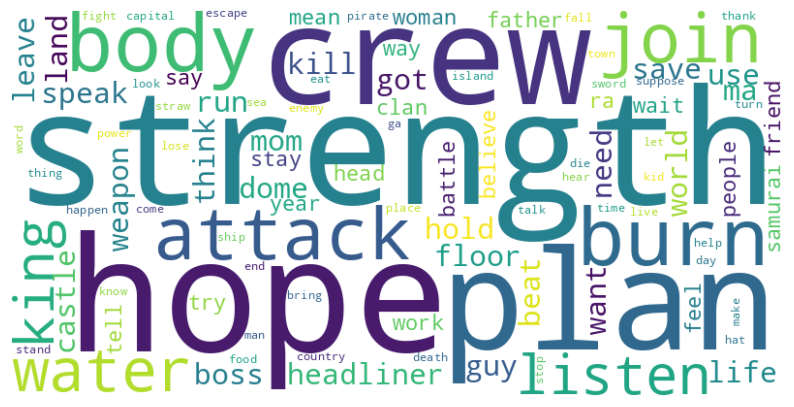

In [16]:
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(onepiecedata_by_saga["processed_text"])

words = vectorizer.get_feature_names_out()[top_n_idx_sparse(X, 100)][13]
sizes = X[13,top_n_idx_sparse(X, 100)[13]].toarray().ravel()
frequencies = {word:size for word in words for size in sizes}

wordcloud = WordCloud(
    width=400,
    height=200,
    scale=2,
    max_font_size=100, 
    background_color="white"
).generate_from_frequencies(frequencies=frequencies)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

This is already amazing! Let's take a look at marineford saga.

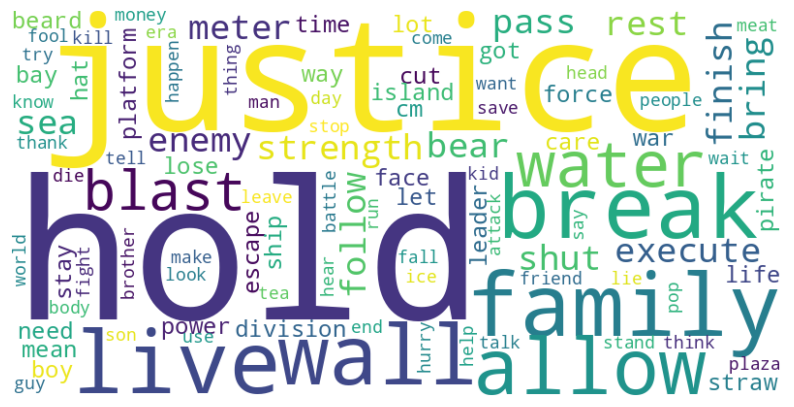

In [17]:
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(onepiecedata_by_saga["processed_text"])

words = vectorizer.get_feature_names_out()[top_n_idx_sparse(X, 100)][7]
sizes = X[7,top_n_idx_sparse(X, 100)[7]].toarray().ravel()
frequencies = {word:size for word in words for size in sizes}

wordcloud = WordCloud(
    width=400,
    height=200,
    scale=2,
    max_font_size=100, 
    background_color="white"
).generate_from_frequencies(frequencies=frequencies)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

And that's all for this notebook! Look for `Embeddings.ipynb` to see more of the analysis!